#### **Fig04_Comparision.ipynb**

Comparison of nonlinear  (a) and linear (b) MPC under equal weighting, showing average BES power (kW), BES energy capacity (kWh), transformer load (%), and HP power (kW) over seven days, representation as a single averaged day with shaded regions indicating min and max values.

In [3]:
# --- Configuration ---
solver = "pyomo_2024_trafo"
#solver = "pyomo_2024_no_trafo"
#solver = "pywraplp"

timesteps = "7584-8256"
data_file = f"../results/{solver}/O1_1.0andO2_0.0/final_2024_model_predictive_{timesteps}_0.0percentnoise_24h.pkl"
#data_file = "../results/pyomo_2024_no_trafo/O1_0.5andO2_0.5/final_2024_model_predictive_7584-8256_0.0percentnoise_24h.pkl"

# Plot file names
fig_name = f"fig004BESpowerSoCTrafoHPPower_{solver}_{timesteps}"
pgf_file_path = f"{fig_name}.pgf"
png_file_path = f"{fig_name}.png"
fig_name = f"fig006BESsubplots_SOC_Ecap{solver}_{timesteps}"

# --- Load SimBench network for max battery energy ---
import simbench as sb
simbench_net = "1-LV-rural1--1-sw"
net = sb.get_simbench_net(simbench_net)
max_e_kwh = net.storage.max_e_mwh * 1000  # Convert MWh to kWh
num_batteries = len(max_e_kwh)

# --- Imports and setup ---
import pickle
import pandapower as pp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Matplotlib / PGF (LaTeX) setup ---
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "pgf.rcfonts": False,
    "font.size": 22
})


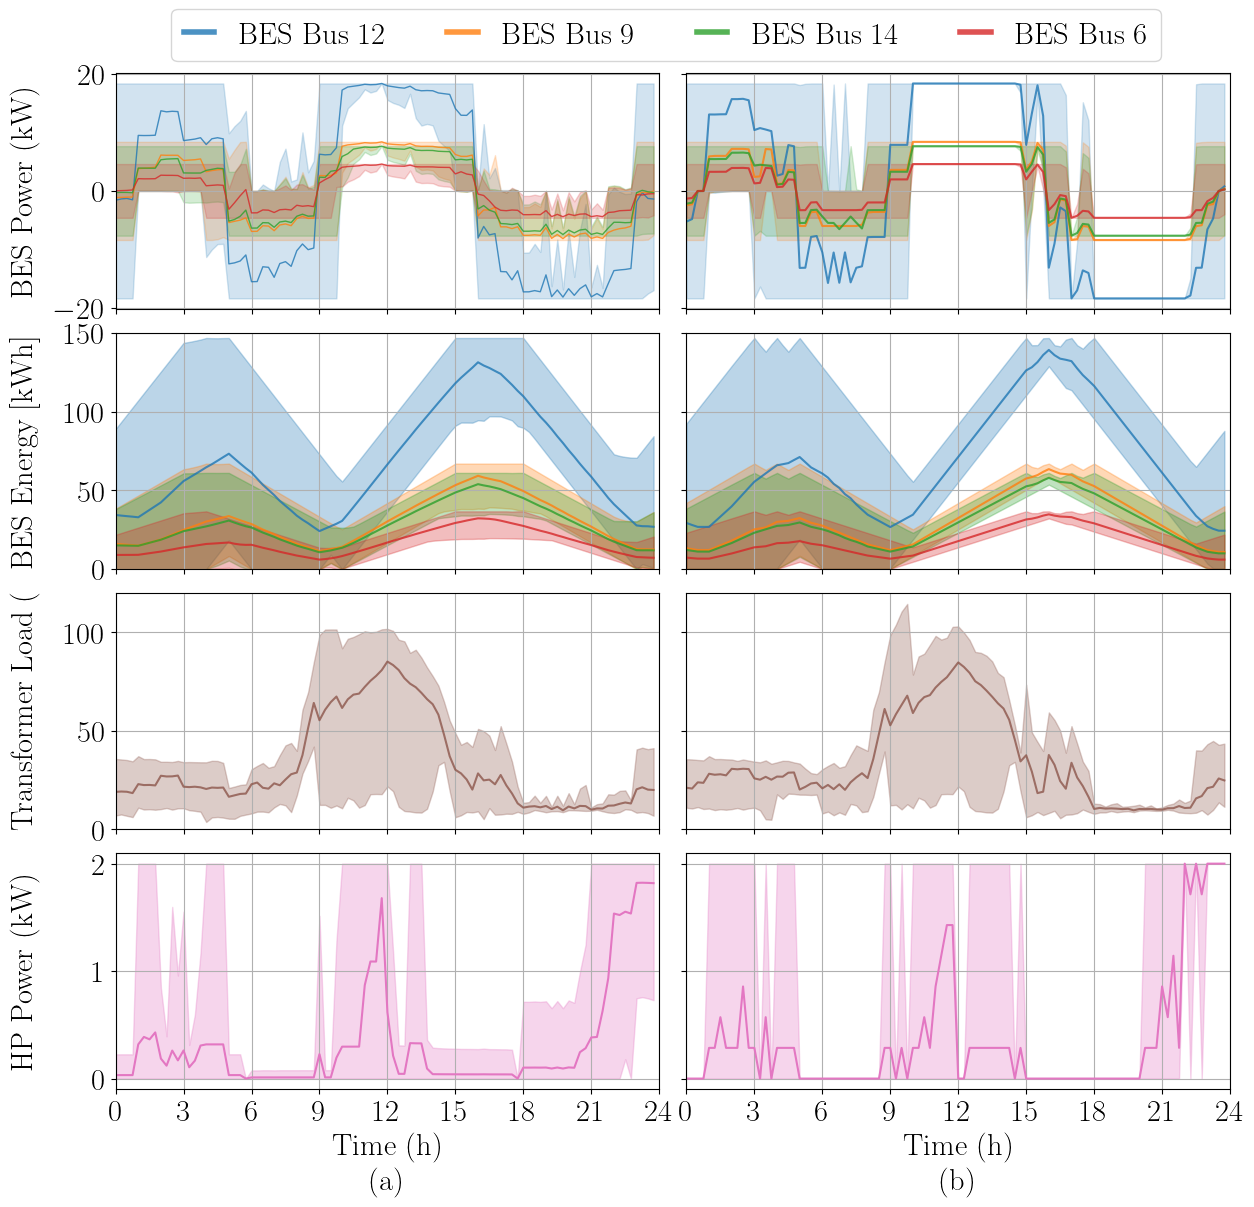

In [4]:
%matplotlib inline  

# -- Simulation parameters --
solver_list = ["pyomo_2024_trafo", "pywraplp"]
timesteps = "7584-8256"

# -- Create figure with 4 rows and 2 columns (one column per solver) --
fig, axes = plt.subplots(4, 2, figsize=(13, 12), sharex=True)

# X-axis ticks and labels (in hours)
steps_per_day = 96
x_ticks = np.linspace(0, steps_per_day, 9)
x_ticklabels = ["0", "3", "6", "9", "12", "15", "18", "21", "24"]

# Battery identifiers
labels_bes_no = ["BES 1", "BES 2", "BES 3", "BES 4"]
labels_bus_no = ["BES Bus 12", "BES Bus 9", "BES Bus 14", "BES Bus 6"]

cmap = plt.get_cmap("tab10")

for col, solver in enumerate(solver_list):
    data_file = f"../results/{solver}/O1_1.0andO2_0.0/final_2024_model_predictive_{timesteps}_0.0percentnoise_24h.pkl"
    with open(data_file, 'rb') as f:
        output_data = pickle.load(f)

    # Extract relevant output variables
    keys = ["out_battery_p_mw", "out_battery_soc", "out_res_trafo_loading_percent", "out_money_spend"]
    data = {key: output_data[key] for key in keys}
    out_battery_p_kw = np.array(data["out_battery_p_mw"]) * 1000  # Convert MW to kW   
    out_battery_soc = np.array(data["out_battery_soc"])
    out_res_trafo_loading_percent = np.array(data["out_res_trafo_loading_percent"])
    out_money_spend = np.array(data["out_money_spend"])
    hp_data = output_data["out_load_p_mw"][-1] * 1000  # Heat pump power in kW

    # Reshape time series to [entity, day, timestep]
    profiles_bat_p_mw_per_day = out_battery_p_kw.reshape(len(out_battery_p_kw), 7, steps_per_day)
    profiles_bat_soc_per_day = out_battery_soc.reshape(len(out_battery_p_kw), 7, steps_per_day)
    profiles_trafo_loading_per_day = out_res_trafo_loading_percent.reshape(7, steps_per_day)
    profiles_money_spend_per_day = out_money_spend.reshape(7, steps_per_day)

    num_batteries = out_battery_p_kw.shape[0]
    num_days = 7

    # Calculate mean and quantiles
    mean_profiles_p = np.mean(profiles_bat_p_mw_per_day, axis=1)
    lower_quantile_p = np.min(profiles_bat_p_mw_per_day, axis=1)
    upper_quantile_p = np.max(profiles_bat_p_mw_per_day, axis=1)

    mean_profiles_soc = np.mean(profiles_bat_soc_per_day, axis=1)
    lower_quantile_soc = np.min(profiles_bat_soc_per_day, axis=1)
    upper_quantile_soc = np.max(profiles_bat_soc_per_day, axis=1)

    mean_profiles_trafo_loading = np.mean(profiles_trafo_loading_per_day, axis=0)
    lower_quantile_trafo_loading = np.min(profiles_trafo_loading_per_day, axis=0)
    upper_quantile_trafo_loading = np.max(profiles_trafo_loading_per_day, axis=0)

    mean_profiles_money_spend = np.mean(profiles_money_spend_per_day, axis=0)
    lower_quantile_money_spend = np.quantile(profiles_money_spend_per_day, 0.01, axis=0)
    upper_quantile_money_spend = np.quantile(profiles_money_spend_per_day, 0.99, axis=0)

    # Heat pump data
    hp_data_reshaped = hp_data.reshape(num_days, steps_per_day)
    avg_hp = np.mean(hp_data_reshaped, axis=0) 
    min_hp = np.min(hp_data_reshaped, axis=0) 
    max_hp = np.max(hp_data_reshaped, axis=0) 

    ax1, ax2, ax3, ax4 = axes[0, col], axes[1, col], axes[2, col], axes[3, col]

    trafo_color = cmap(5)  # Color for transformer loading
    hp_color = cmap(6)     # Color for heat pump power

    # 1) Battery Power
    for i in range(num_batteries):
        color_i = cmap(i)
        ax1.plot(mean_profiles_p[i], label=labels_bus_no[i], alpha=0.8, color=color_i)
        ax1.fill_between(range(steps_per_day), lower_quantile_p[i], upper_quantile_p[i], color=color_i, alpha=0.2)
    ax1.set_ylabel("BES Power (kW)", labelpad=10)
    ax1.grid(True)

    # 2) State of Charge (SoC)
    for i in range(num_batteries):
        color_i = cmap(i)
        ax2.plot((mean_profiles_soc[i] / 100) * max_e_kwh[i], label=labels_bus_no[i], alpha=0.8, color=color_i)
        ax2.fill_between(range(steps_per_day),
                         (lower_quantile_soc[i] / 100) * max_e_kwh[i],
                         (upper_quantile_soc[i] / 100) * max_e_kwh[i],
                         color=color_i, alpha=0.3)
    ax2.set_ylim([0, 150])
    ax2.set_ylabel("BES Energy [kWh]", labelpad=10)
    ax2.grid(True)

    # 3) Transformer Loading
    ax3.plot(mean_profiles_trafo_loading, label="Transformer Load", color=trafo_color, alpha=0.8)
    ax3.fill_between(range(steps_per_day), lower_quantile_trafo_loading, upper_quantile_trafo_loading,
                     color=trafo_color, alpha=0.3)
    ax3.set_ylabel("Transformer Load (%)", labelpad=10)
    ax3.set_ylim([0, 120])
    ax3.grid(True)

    # 4) Heat Pump Power
    ax4.plot(avg_hp, color=hp_color, alpha=1.0, label="HP Power")
    ax4.fill_between(range(steps_per_day), min_hp, max_hp, color=hp_color, alpha=0.3)
    ax4.set_ylabel("HP Power (kW)", labelpad=10)
    ax4.grid(True)

    # Hide Y-axis labels on the right column
    if col == 1:
        for ax in [ax1, ax2, ax3, ax4]:
            ax.set_ylabel(None)
            ax.tick_params(labelleft=False)

    # X-axis ticks and labels
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlim([0, steps_per_day])
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticklabels)

# -- Global legend from first subplot --
handles, labels = axes[0, 0].get_legend_handles_labels()
for handle in handles:
    handle.set_linewidth(4.0)
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.53, 1.03), ncol=4, handlelength=1)
for handle in handles:
    handle.set_linewidth(1.0)

# X-axis label for bottom plots
axes[3, 0].set_xlabel("Time (h)\n(a)")
axes[3, 1].set_xlabel("Time (h)\n(b)")

fig.align_ylabels(axes[:, 0])
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.05)
plt.show()

# -- Optional export --
fig.savefig("comparisonNLPvsMILPsolvers.pgf", bbox_inches="tight")
# fig.savefig("comparison_2_solvers.png", bbox_inches="tight") 